## **Исследование факторов открытия депозита в банке**

**Задача:**

Банк провел маркетинговую кампанию привлечения клиентов для открытия депозита. Необходимо проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент открыл депозит.

In [179]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import IsolationForest, GradientBoostingClassifier

import optuna

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-dark')


### Знакомство с данными, обработка пропусков и выбросов

*Данные о клиентах банка:*

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

*Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:*

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

*Прочие признаки:*

* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

*Целевая переменная:*

* deposit (согласится ли клиент открыть депозит в банке)

In [180]:
# Загрузка данных
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [181]:
#Информация о структуре данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


> * В выборке 11162 записи и 17 признаков.
> * Признаки 'job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'contact', 'poutcome' - категориальные, тип 'object', требуется кодирование.
> * В признаке 'balance' есть пропуски данных и требуется преобразование к числовому виду.  
> * Поля 'age', 'day', 'duration', 'campaign', 'pdays', 'previous' - тип int
> * Целевой признак 'deposit' - категориальный, тип 'object' - необходимо преобразование к бинарному.
>
> *В признаках типа 'object' присутствуют значения 'unknown', что можно расссматриваит как пропуски данных*

In [182]:
#Создадим списки факторов
target = 'deposit' # целевой признак
category_features = df.drop(columns=[target, 'balance']).select_dtypes('object').columns.to_list() #Категориальные
numeral_features = df.drop(columns=category_features + [target]).columns.to_list() #Числовые

#### Заполнение пропусков в данных

**Заполнение пропусков признака 'balanse' медианным значением**

In [183]:
# преобразуем поле к типу float
# избавимся от знака доллара, пробелов между цифрами и меняем десятичную запятую на точку 
df['balance'] = df[df['balance'].notnull()]['balance'].apply(
    lambda x: str(x).replace(',','.').replace(' ','')[:-2]).apply(
        lambda x: 0 if str(x) == '' else x)
    
# Конвертируем в тип float
df['balance'] = df['balance'].astype(float)

#Заполним пропуски медианным значением
df['balance'].fillna(df['balance'].median(), inplace=True)

df['balance'].isna().any() # Проверяем полноту данных

np.False_

**Заполнение значений 'unknown' в категориальных полях**

In [184]:
# Исследуем признаки типа object на наличие категории 'unknown'
        
for i, feature in enumerate(category_features):
    if df[df[feature] == 'unknown'].shape[0] > 0 :
        print(f"В признаке {feature} {round(df[feature].value_counts(normalize=True)['unknown']*100,1)} % значений 'unknown'")

В признаке job 0.6 % значений 'unknown'
В признаке education 4.5 % значений 'unknown'
В признаке contact 21.0 % значений 'unknown'
В признаке poutcome 74.6 % значений 'unknown'


> Признаки, имеющие значения 'unknown':
> * 'job' - 70 (0,6%) - можно заполнить модой.
> * 'education' - 497 (4,5%) - можно заполнить модой.
> * 'contact' - 2346 (21%) - для заполнения необходимы дополнительные данные
> * 'poutcome' - 8326 (74%) - скорее всего, сведений не найти.

In [185]:
# заполнение пропусков в поле 'job'
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x.strip() == 'unknown' else x)

# заполнение пропусков в поле 'education'
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x.strip() == 'unknown' else x)

# проверка
print(df[df['job'] == 'unknown'].shape[0])
print(df[df['education'] == 'unknown'].shape[0])

0
0


#### Исследование и удаление выбросов числовых данных

In [186]:
# Цветовая схема
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0.2,1,len(numeral_features)))

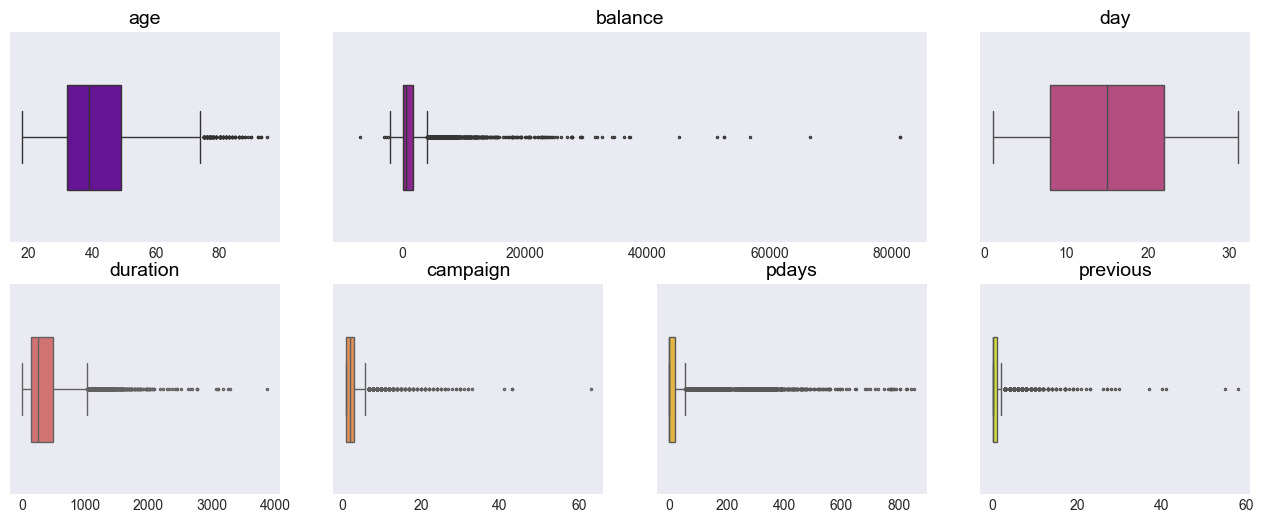

In [187]:
# Выбросы в числовых данных
fig = plt.figure(figsize=(16,6))

shift = 1
for i, feature in enumerate(numeral_features):
    if feature == 'balance':
        shift=2
        ax = fig.add_subplot(2,4,(i+1, i+shift), label=feature)
    else:
        ax = fig.add_subplot(2,4,i+shift, label=feature)
    sns.boxplot(df, x=feature, orient='h',  color=colors[i], width=0.5, fliersize=1.5, ax=ax)
    ax.set_title(feature, fontdict={'size': 14, 'color':'black'})
    ax.set_xlabel('')
plt.show();

> У всех признаков, за исключением признака 'days' есть выбросы. Исследуем их и примем решение об удалении

**Выбросы признака 'age'**

Присутствуют клиенты, возраст которых превышает 90 лет. Исследуем их данные

In [188]:
df[df['age'] > 90]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
1582,95,retired,divorced,primary,no,2282.0,no,no,telephone,21,apr,207,17,-1,0,unknown,yes
2802,92,retired,married,secondary,no,775.0,no,no,cellular,22,oct,313,3,-1,0,unknown,yes
3098,92,retired,married,secondary,no,775.0,no,no,cellular,26,jan,164,4,96,3,success,yes
3756,93,retired,married,secondary,no,775.0,no,no,cellular,22,jul,860,2,177,7,success,yes
3822,93,retired,married,secondary,no,775.0,no,no,cellular,4,aug,476,2,13,9,success,yes


> Судя по записям, все клиенты активны, имеют депозиты, хотя у четверых из них баланс заполнен при восстановлени пропусков данных, с троими был успешный контакт в предыдущую маркетинговую кампанию и есть связь в текущую. Удаление выбросов проводить не надо.

**Выбросы признака 'duration'**

С некоторыми клиентами общение длилось более 3000 секунд (50 минут). Исследуем записи.

In [189]:
df[df['duration'] > 3000]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
153,44,services,divorced,secondary,no,51.0,yes,yes,unknown,27,may,3094,2,-1,0,unknown,yes
271,59,management,married,secondary,no,1321.0,no,no,unknown,9,jun,3881,3,-1,0,unknown,yes
358,28,admin.,single,secondary,no,-7.0,no,yes,unknown,26,jun,3183,2,-1,0,unknown,yes
883,36,self-employed,single,tertiary,no,-103.0,yes,yes,telephone,17,oct,3253,1,-1,0,unknown,yes
1351,47,blue-collar,married,secondary,no,238.0,yes,yes,cellular,13,mar,3076,1,-1,0,unknown,yes
4364,53,admin.,married,secondary,no,849.0,yes,no,cellular,6,feb,3102,3,-1,0,unknown,yes
7198,30,admin.,married,secondary,no,1310.0,no,no,telephone,27,oct,3284,1,-1,0,unknown,no


> У всех клиентов, кроме одного, есть депозиты. У троих клиентов указаны месяц, день и длительность контакта, но способ контакта не указан. Были контакты в предыдущую маркетинговую кампанию, результат неизвестен. Удалять записи не надо.

**Выбросы признака 'campaign'**

С некоторыми клиентами число контактов в текущую кампнию превышает 40. Исследуем записи.

In [190]:
df[df['campaign']>40]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
6927,51,blue-collar,married,secondary,no,41.0,yes,no,telephone,9,jul,16,43,-1,0,unknown,no
7139,42,blue-collar,married,primary,no,170.0,yes,no,unknown,19,may,51,41,-1,0,unknown,no
7240,33,blue-collar,married,secondary,no,0.0,yes,yes,cellular,31,jul,16,43,-1,0,unknown,no
7635,45,management,married,secondary,no,9051.0,yes,no,unknown,19,may,124,63,-1,0,unknown,no


> У всех результаты предыдущей маркетинговой кампании неизвестны, низкий баланс (кроме одного), нет депозитов, но есть кредиты на недвижимость и у одного клиента потребительский кредит. Удалять данные не надо.

**Выбросы признака 'pdays'**

С некоторыми клиентами контакта с предыдущей маркетинговой кампании не было более 2-х лет. Исследуем записи.

In [191]:
df[df['pdays'] > 730]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
3677,37,technician,married,secondary,no,432.0,yes,no,cellular,6,jul,386,3,776,55,failure,yes
3766,37,technician,married,secondary,no,1707.0,yes,no,cellular,26,jul,546,2,784,3,failure,yes
3874,34,blue-collar,married,secondary,no,320.0,yes,no,cellular,12,aug,352,1,828,2,failure,yes
3892,60,services,married,tertiary,no,4256.0,yes,no,cellular,16,aug,239,3,761,1,other,yes
3950,33,unemployed,single,secondary,no,2066.0,no,yes,cellular,9,sep,305,1,749,2,failure,yes
3973,38,management,married,tertiary,no,1477.0,no,no,cellular,15,sep,385,3,769,2,failure,yes
3981,60,retired,married,secondary,no,975.0,no,no,cellular,16,sep,303,1,792,1,failure,yes
3988,37,management,divorced,tertiary,no,488.0,yes,no,cellular,17,sep,328,1,854,2,failure,yes
4001,31,housemaid,married,secondary,no,243.0,yes,no,cellular,23,sep,305,2,842,1,failure,yes
4482,31,blue-collar,married,secondary,no,0.0,yes,no,unknown,10,aug,97,1,782,1,other,yes


> Все клиенты вышли на контакт в текущую маркетинговую кампанию, имеют неотрицательный баланс, большинство имеют депозиты. Удалять не будем.

**Выбросы признака 'balance'**

С некоторыми клиентами контакта с предыдущей маркетинговой кампании не было более 2-х лет. Исследуем записи.

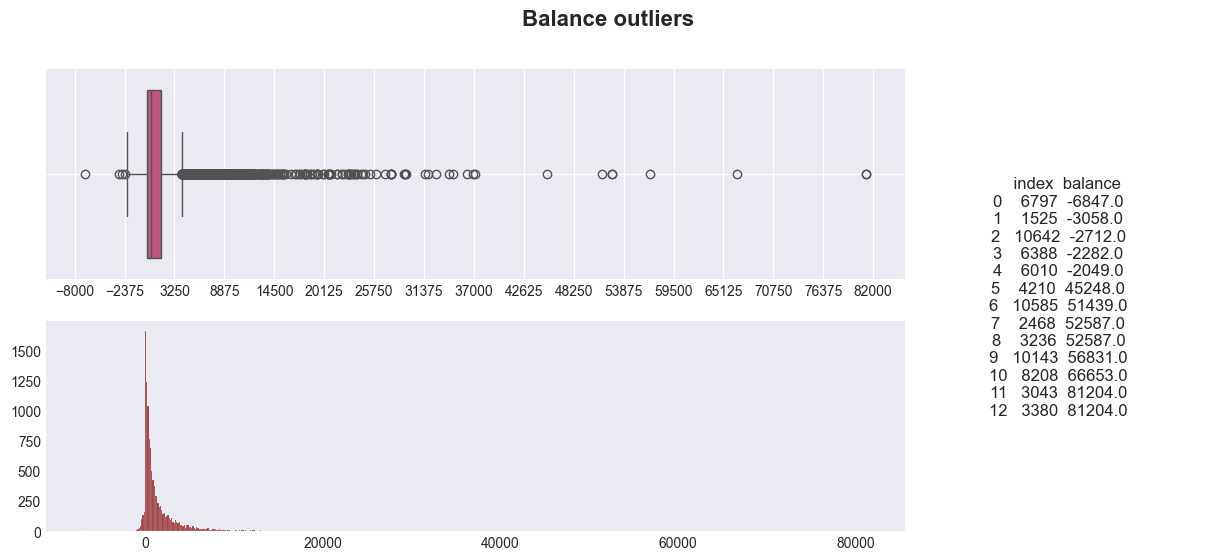

In [192]:
# Распределение признака balance
fig = plt.figure(figsize=(15,6))
fig.suptitle('Balance outliers', fontsize=16, fontweight='bold')
ax1 = fig.add_subplot(2,4,(1,3))
ax3 = fig.add_subplot(2,4,(5,7))
ax2 = fig.add_subplot(1,4,4)
ax2.set_axis_off()
sns.boxplot(df, x='balance', orient='h', palette='plasma', ax=ax1)
ticks = list(np.linspace(-8000,82000, 17).astype('int'))
ax1.set_xticks(ticks)
ax1.set_xlabel('')
ax1.grid(visible=True)
sns.histplot(df, x='balance', cbar=True, color='maroon', edgecolor='white', ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('')
txt = df[(df['balance'] > 40000)|(df['balance'] < -2000)]['balance'].sort_values().reset_index()
fig.text(0.8, 0.5, txt, horizontalalignment='center', verticalalignment='center', fontdict={'size': 12})
plt.show();

> Имеем явные выбросы по признаку 'balance': в отрицательной части шкалы это значения меньшие -2000, в положительной части шкалы - значения, большие 37000. Удалим выбросы.

**Удаление выбросов признака 'balance' методом Тьюки**

In [193]:
#Вычислим границы поиска
IRQ = df['balance'].quantile(0.75) - df['balance'].quantile(0.25)
bottom = df['balance'].quantile(0.25) - 1.5 * IRQ
top = df['balance'].quantile(0.75) + 3 * IRQ # Распределение смещено вправо, отодвинем правую границу 

print(f'{bottom:.0f}, {top:.0f}')

-2241, 6427


In [194]:
# Удалим выбросы
rows_before = df.shape[0]
df.drop(df[(df['balance']<bottom)|(df['balance']>top)].index, axis=0, inplace=True)
print(f'{rows_before - df.shape[0]} rows deleted, the sample shape is', df.shape)

518 rows deleted, the sample shape is (10644, 17)


### Разведывательный анализ данных

#### Соотношение классов целевой переменной

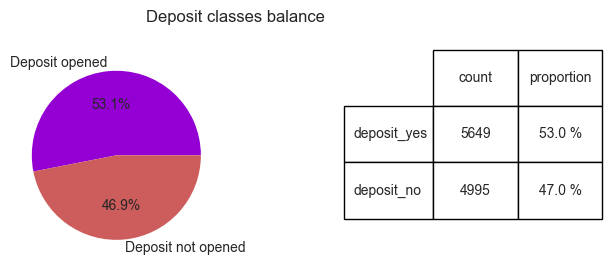

In [195]:
colors = cmap(np.linspace(0.3,0.5,2))

fig = plt.figure(figsize=(6,3))
plt.suptitle('Deposit classes balance')

ax = fig.add_subplot(1,2,1)

ax.pie( x=df['deposit'].value_counts(), autopct='%1.1f%%', colors=['darkviolet','indianred'], 
       labels=['Deposit opened', 'Deposit not opened'])
deposit_df = pd.concat(
    [df['deposit'].value_counts(),
     round(df['deposit'].value_counts(normalize=True)*100).astype(object).apply(lambda x: str(x)+' %')], axis=1).reset_index()

col_labels = list(deposit_df.drop('deposit', axis=1).columns)
row_labels = ['deposit_'+item for item in list(deposit_df['deposit'])[::-1]]
# colors = plt.cm.BuPu(np.linspace(0.3, 0.1, len(row_labels)))
colors_lst = np.empty(deposit_df[col_labels].shape, dtype=str)
colors_lst.fill('b')
dt = np.array(deposit_df[col_labels]).tolist()
ax.table(cellText = dt, cellLoc='center',
          rowLabels=row_labels, 
          colLabels=col_labels,
          bbox=[2,0.2,0.8,0.8]);

> * Целевой признак имеет 2 значения, возможно преобразование к бинарному.
> * Дисбаланс классов незначительный

#### Описание количественных признаков

In [196]:
# Выведем таблицу описания признаков
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10644.000000,10644.000000,10644.000000,10644.000000,10644.000000,10644.000000,10644.000000
mean,41.076381,1021.495678,15.640361,371.525554,2.504791,51.143743,0.825442
std,11.828645,1347.577934,8.430533,347.792521,2.672249,109.019894,2.275733
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,108.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,38.500000,497.000000,15.000000,254.000000,2.000000,-1.000000,0.000000
75%,49.000000,1440.250000,22.000000,495.000000,3.000000,6.500000,1.000000
max,95.000000,6422.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


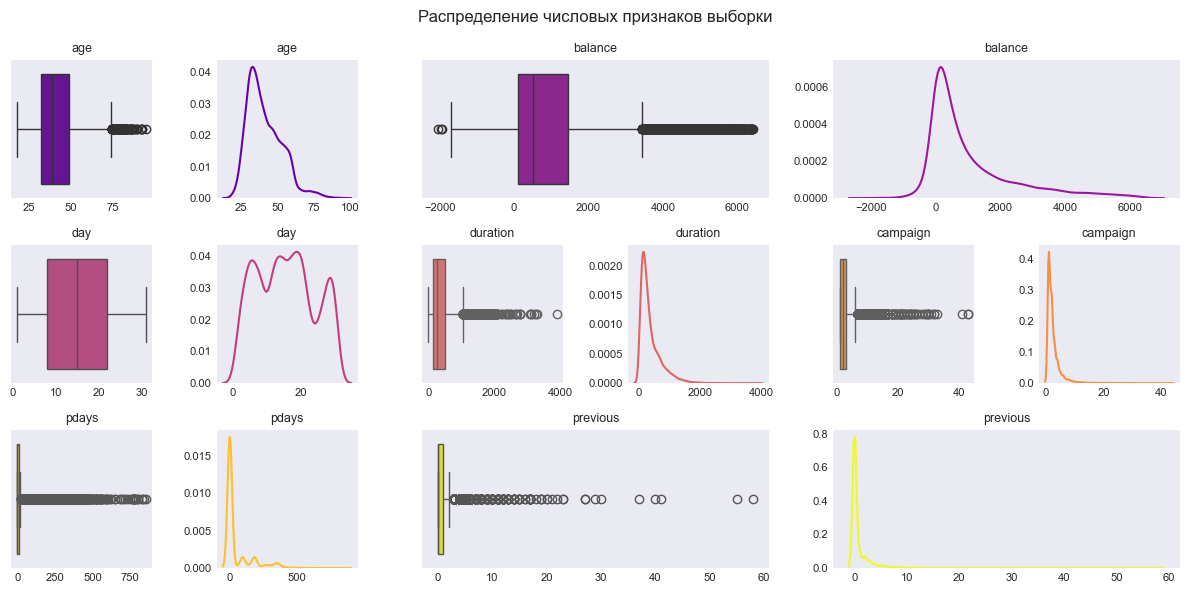

In [197]:
# Диаграммы распределения признаков
fig = plt.figure(figsize=(12,6))
colors = cmap(np.linspace(0.2,1,len(numeral_features)))
fig.suptitle('Распределение числовых признаков выборки')
i = 1
for feature, color in zip(numeral_features, colors):
    
    if feature == 'balance' or feature == 'previous':
        ax1 = fig.add_subplot(3,6,(i,i+1))
        sns.boxplot(df, x=feature, color=color, ax=ax1)
        ax2 = fig.add_subplot(3,6,(i+2,i+3))
        sns.kdeplot(df, x=feature, color=color, ax=ax2)
        i += 4
    else:
        ax1 = fig.add_subplot(3,6,i)
        sns.boxplot(df, x=feature, color=color, ax=ax1)
        ax2 = fig.add_subplot(3,6,i+1)
        sns.kdeplot(df, x=feature, color=color, ax=ax2)
        i += 2
    ax1.set_title(feature, fontsize=9)
    ax1.set_ylabel('')
    ax1.set_xlabel('')
    ax1.tick_params(labelsize=8)
    ax2.set_title(feature, fontsize=9)
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.tick_params(labelsize=8)
fig.tight_layout()
fig.show();

> * Имеем большой разброс диапазонов данных (от 0 - 58 со средним 0.8 для признака 'previous' до -2049 до 6422 со средним 1021 для признака 'balance')
> * Признак 'day' имеет распределение, похожее на равномерное.
> * Остальные признаки имеют смещение распределения влево.
> * *Требуется нормализация непрерывных признаков*

#### Описание категориальных признаков

In [198]:
df[category_features].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10644,10644,10644,10644,10644,10644,10644,10644,10644
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2465,6039,5769,10477,5543,9212,7657,2733,7963


#### Исследование данных о клиентах

**Исследуем, в каком возрасте клиенты более склонны открывать депозит**

Процент клиентов с депозитом в возрастных группах младше 29 и старше 60 лет
deposit
yes    68.0
no     32.0
Name: proportion, dtype: float64
----------------------------------------
Процент клиентов с депозитом в возрастных группах от 29 до 60 лет
deposit
no     57.0
yes    43.0
Name: proportion, dtype: float64


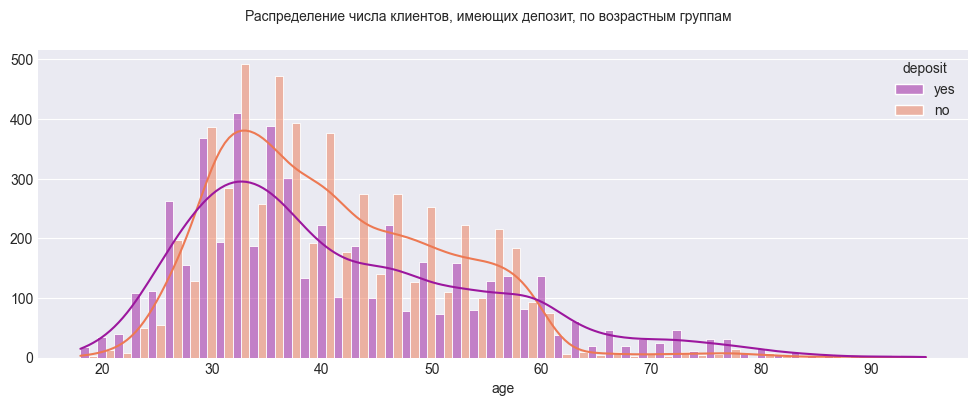

In [199]:
print('Процент клиентов с депозитом в возрастных группах младше 29 и старше 60 лет')
print((df[(df['age']<29)|(df['age']>60)]['deposit'].value_counts(normalize=True) * 100).round())
print('-'*40)
print('Процент клиентов с депозитом в возрастных группах от 29 до 60 лет')
print((df[(df['age']>=29)&(df['age']<=60)]['deposit'].value_counts(normalize=True, ascending=False) * 100).round())
fig = plt.figure(figsize=(12,4))
fig.suptitle('Распределение числа клиентов, имеющих депозит, по возрастным группам', fontsize=10)
hist1 = sns.histplot(df, x='age', hue='deposit', palette='plasma', kde=True, multiple='dodge', edgecolor='w')
plt.grid(visible=True, axis='y')
plt.ylabel('');

> * В возрастных категориях до 29 лет и старше 60 лет число клиентов с депозитом выше, чем число клиентов без депозита, причем, в возрасте до 25 лет и выше 65 лет более 50% клиентов имеют депозиты.
> * В возрасте от 29 до 60 лет число клиентов без депозита превышает число клиентов с депозитом примерно на 15%.

**Исследуем, клиенты с каким балансом более склонны открывать депозит**

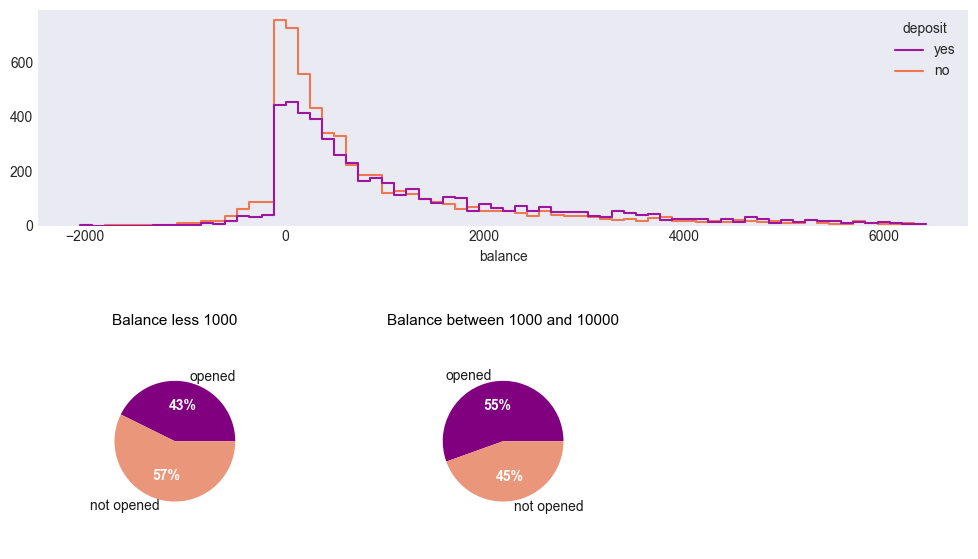

In [200]:
def deposit_pie(subplot, data, title):
     wedges, texts, autotexts = subplot.pie(data, 
                                            radius = 0.7, colors=['purple', 'darksalmon', 'darkslateblue','lightsteelblue'], 
                                            autopct='%1.0f%%', labels=['opened', 'not opened'], 
                                            textprops=dict(color='w', weight='bold'))
     subplot.set_title(title, fontdict={'color': 'black', 'size': 11})
     plt.setp(texts, color='#1A1A1A', weight='normal')   

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,3,(1,3))
sns.histplot(df, x='balance', hue='deposit', element="step", fill=False, palette='plasma', ax=ax1)
ax1.set_ylabel('')
deposit_pie(fig.add_subplot(2,3,4), 
            df[df['balance'] <=1000]['deposit'].value_counts().sort_index(ascending=False), 
            'Balance less 1000')
deposit_pie(fig.add_subplot(2,3,5), 
            df[(df['balance'] >1000)&(df['balance'] <10000)]['deposit'].value_counts().sort_index(ascending=False), 
            'Balance between 1000 and 10000')
# deposit_pie(fig.add_subplot(2,3,6), 
#             df[df['balance'] >= 10000]['deposit'].value_counts().sort_index(ascending=False), 
#             'Balance more than 10000')
plt.subplots_adjust(hspace=0.5)
plt.show();

> Клиенты с балансом выше 1000$ более склонны открывать депозит, разница между числом тех, кто открыл депозит и тех, кто не открыл депозит, составляет 10%.

**Исследуем, клиенты с каким уровнем образования более склонны открывать депозит**

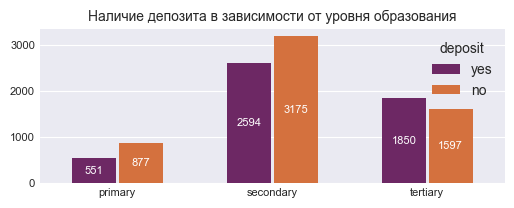

In [201]:
# Метки для диаграммы
fig = plt.figure(figsize=(6,2))
cp = sns.countplot(df, x='education', order=['primary', 'secondary', 'tertiary'], 
                   hue='deposit', palette='inferno', width=0.6, gap=0.05)
plt.grid(visible=True, axis='y')
plt.title('Наличие депозита в зависимости от уровня образования', fontdict={'size':10})
plt.xlabel('')
plt.tick_params(labelsize=8)
plt.ylabel('')
cp.bar_label(cp.containers[0], fontsize=8, label_type='center', color='w')
cp.bar_label(cp.containers[1], fontsize=8, label_type='center', color='w');

> * Более склонны открывать депозит клиенты с высшим образованием (разница составляет 253 человека или 8%)
> * Наиболее многочисленна группа клиентов, имеющих среднее образование. Среди них число тех, у кого нет депозита, превышает число клиентов с депозитом (разница составляет 581 человек или 10%)
> * Среди клиентов, имеющих начальное образование (самая малочисленная группа), разница между открывшими депозит и не имеющими депозит наибольшая (число тех, кто не открыл депозит на 326 человек или на 22% больше, чем тех, кто имеет депозит)

**Зависимость наличия депозита от позиции на работе**

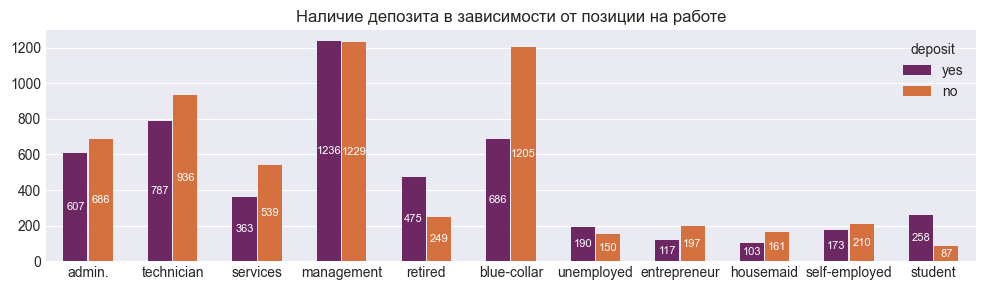

In [202]:
fig = plt.figure(figsize=(12,3))
cp = sns.countplot(df, x='job', hue='deposit', palette='inferno', width=0.6, gap=0.05)
plt.grid(visible=True, axis='y')
plt.title('Наличие депозита в зависимости от позиции на работе')
plt.xlabel('')
plt.ylabel('')
cp.bar_label(cp.containers[0], fontsize=8, label_type='center', color='w')
cp.bar_label(cp.containers[1], fontsize=8, label_type='center', color='w');


> * Превышение числа клиентов, открывших депозит, наблюдается в группах "retired" (пенсионеры), "unemployed" (безработные) и "students" (студенты). Причем, количество студентов с депозитом вдвое превышает число студентов без депозита(скорее всего, депозиты на образование, открытые и собираемые ранее).
> * В 'management' (управляющий персонал) число людей с депозитом и без депозита распределено почти пополам.
> * Наименьший относительный процент открытия депозитов в группе "blue_collar" (рабочая специальность). Число клиентов с депозитом почти в два раза ниже, чем число клиентов без депозита.
> * В остальных группах чило клиентов без депозита больше, чем число клиентов с депозитом.

**Зависимость наличия депозита от семейного положения**

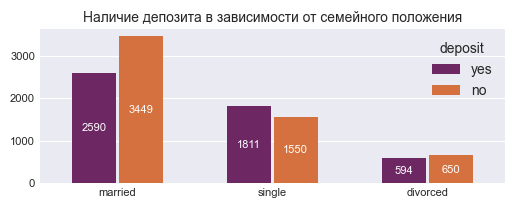

In [203]:
fig = plt.figure(figsize=(6,2))
cp = sns.countplot(df, x='marital', hue='deposit', palette='inferno', width=0.6, gap=0.05)
plt.grid(visible=True, axis='y')
plt.title('Наличие депозита в зависимости от семейного положения', fontdict={'size':10})
plt.xlabel('')
plt.ylabel('')
plt.tick_params(labelsize=8)
cp.bar_label(cp.containers[0], fontsize=8, label_type='center', color='w')
cp.bar_label(cp.containers[1], fontsize=8, label_type='center', color='w');

> * У разведенных клиентов группы с депозитом и без разделяются приблизительно пополам.
> * Семейных клиентов, имеющих депозит, примерно на 20% меньше, чем не имеющих депозит (2590 против 3449). 
> * У клиентов без семьи наличие депозита встречается примерно на 10% чаще (1811 против 1550).

**Зависимость открытия депозита от наличия кредита**

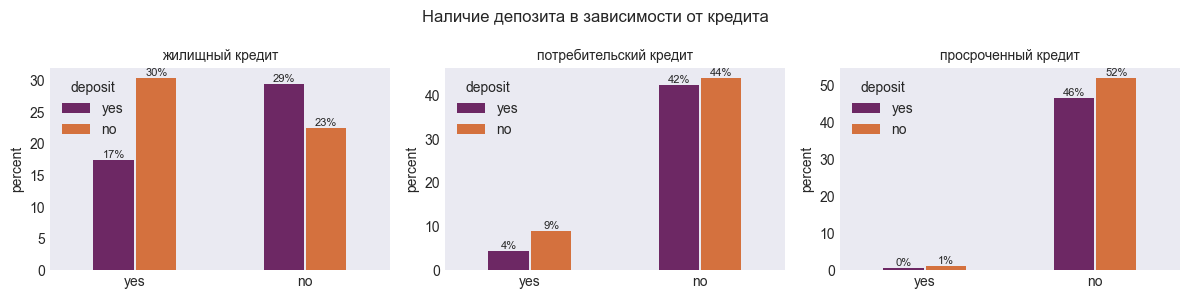

In [204]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Наличие депозита в зависимости от кредита')

def add_plot(data, feature, subplot, title):
    ax = plt.subplot(1,3,subplot)
    sns.countplot(data, x=feature, order = ['yes', 'no'], 
                  hue='deposit', stat='percent',
                  palette='inferno', width=0.5, gap=0.05, ax=ax)
    ax.set_title(title, fontdict={'size': 10})
    ax.set_xlabel('')
    ax.bar_label(ax.containers[0], fontsize=8, fmt='%.0f%%')
    ax.bar_label(ax.containers[1], fontsize=8, fmt='%.0f%%');

features = ['housing', 'loan', 'default']
titles = ['жилищный кредит', 'потребительский кредит','просроченный кредит']    
for i, feature, title in zip(range(1,4), features, titles):
    add_plot(df, feature, i, title)
fig.tight_layout();


> Результаты исследования данных о клиентах:
> * Более склонны открывать депозит клиенты моложе 30 лет и старше 60 лет.
> * Клиенты с высоким балансом более склонны открывать депозит.
> * Более склонны открывать депозит люди с высшим образованием.
> * Наименьший относительный процент открытия депозитов в группе "blue_collar".
> * Превышение числа клиентов, открывших депозит, наблюдается в группах "management", "retired", "unemployed" и "students" (для последних это, скорее всего, депозиты на образование, открытые и собираемые ранее)
> * Чаще открывают депозит клиенты, у которых нет семьи.
> * Более склонны открывать депозит клиенты, у которых нет кредитов.

#### Исследование данных о маркетинговой кампании

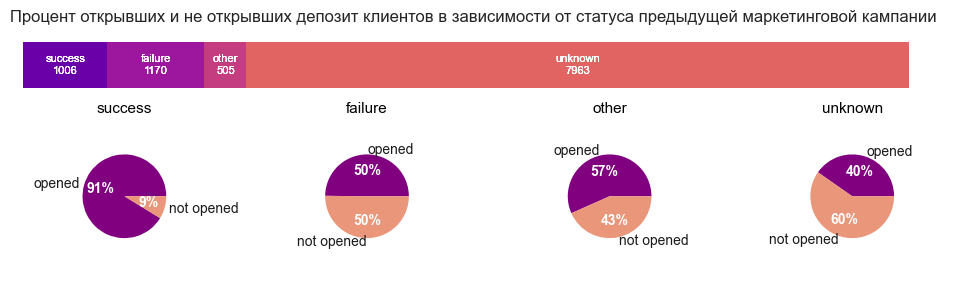

In [205]:
# Для какого статуса предыдущей маркетинговой кампании 
# успех в текущей превалирует над количеством неудач.
poutcome_deposit = df.pivot_table(index='deposit', 
                                  columns='poutcome', 
                                  values='age', 
                                  aggfunc='count').reset_index().sort_values('deposit', 
                                                                             ascending=False)
fig = plt.figure(figsize=(12,3))
fig.suptitle('Процент открывших и не открывших депозит клиентов в зависимости от статуса предыдущей маркетинговой кампании')

ax = fig.add_subplot(4,4,(1,4), facecolor='w')
df_copy = df['poutcome'].value_counts().to_dict()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
left = np.zeros(4)
x=0
for poutcome, color in zip(['success', 'failure', 'other', 'unknown'], colors):
    length = df_copy[poutcome]
    ax = plt.barh(x, length, height=0.001, label=poutcome, color=color, left=left)
    plt.bar_label(ax, label_type='center', fmt=lambda x: f'{poutcome}\n{x:.0f}', fontsize=8, color='w')
    left += length

for i, item in enumerate(['success', 'failure', 'other', 'unknown']):
    ax = fig.add_subplot(3,4,(i+5, i+9))
    deposit_pie(ax, poutcome_deposit[item], item)

plt.show();

> * Результат проведения предыдущей маркетинговой кампании известен для примерно 20% клиентов банка, из них с 1006 клиентами контакт прошел успешно, 1170 клиентов не откликнулись на кампанию. Результат кампании для почти 80% клиентов неизвестен.
> * Среди клиентов, контакт с которыми в маркетинговой кампании был успешен, 91% открыли депозит.
> * Среди клиентов, с которыми не был установлен контакт в маркетинговую кампанию, 50% открыли депозит.
> * Среди клиентов, результат общения с которыми неизвестен, открыли депозит 40%.

**Распределение числа согласий и отказов открыть депозит по месяцам**

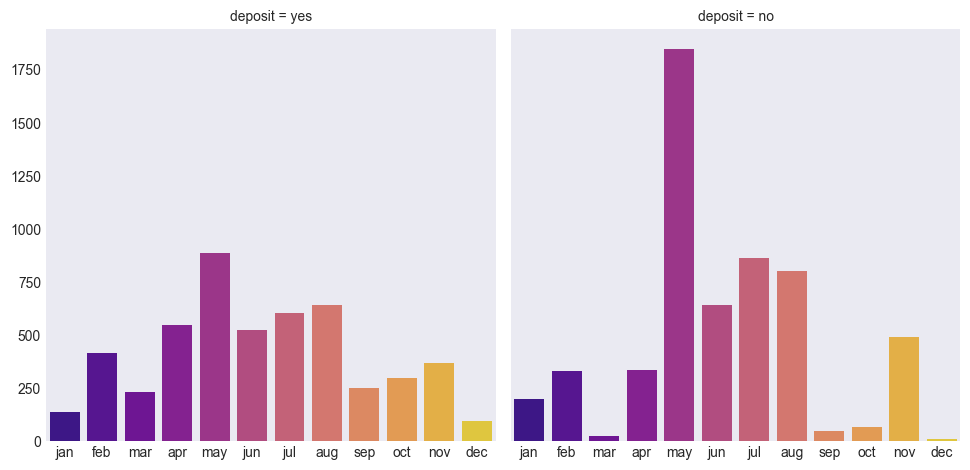

In [206]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
ax = sns.catplot(df, x='month', kind='count', col='deposit', order=months, palette='plasma')
ax.set_xlabels('')
ax.set_ylabels('')
plt.show()

> * Наибольшее число отказов открыть депозит, как и наибольшее число согласий приходится на май. Однако, в этом месяце число отказов более чем в 2 раза превысило число согласий.

### Преобразование данных

In [207]:
df_copy = df.copy()

#### Порядковое кодирование признака 'education'

**Кодирование признака 'education' методом LabelEncoding**

In [208]:
# Кодирование LabelEncoding
encoder = preprocessing.LabelEncoder()
data_encoded = encoder.fit_transform(pd.DataFrame(df['education']))
df['education'] = data_encoded

**Бинарное кодирование признаков 'default','housing', 'loan', 'deposit'**

In [209]:
def bin_feature_encoding(data, feature):
    encoder = preprocessing.LabelEncoder()
    data[feature] = encoder.fit_transform(data[feature])
    
features_bin = ['default','housing', 'loan', 'deposit']
for feature in features_bin:
    bin_feature_encoding(df, feature)
    
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1


**Кодирование остальных категориальных признаков**

In [210]:
features = list(df.select_dtypes('object')) # Список факторов для кодирования

features_encoded = pd.get_dummies(df[features]) # Кодируем признаки
df = pd.concat([df,features_encoded], axis=1) # Добавляем закодированные признаки в таблицу

# Удаляем закодированные признаки
df.drop(columns = features, inplace=True)
df.shape

(10644, 45)

####  Исследование мультиколлинеарности признаков

**Корреляция целевого признака с факторами**

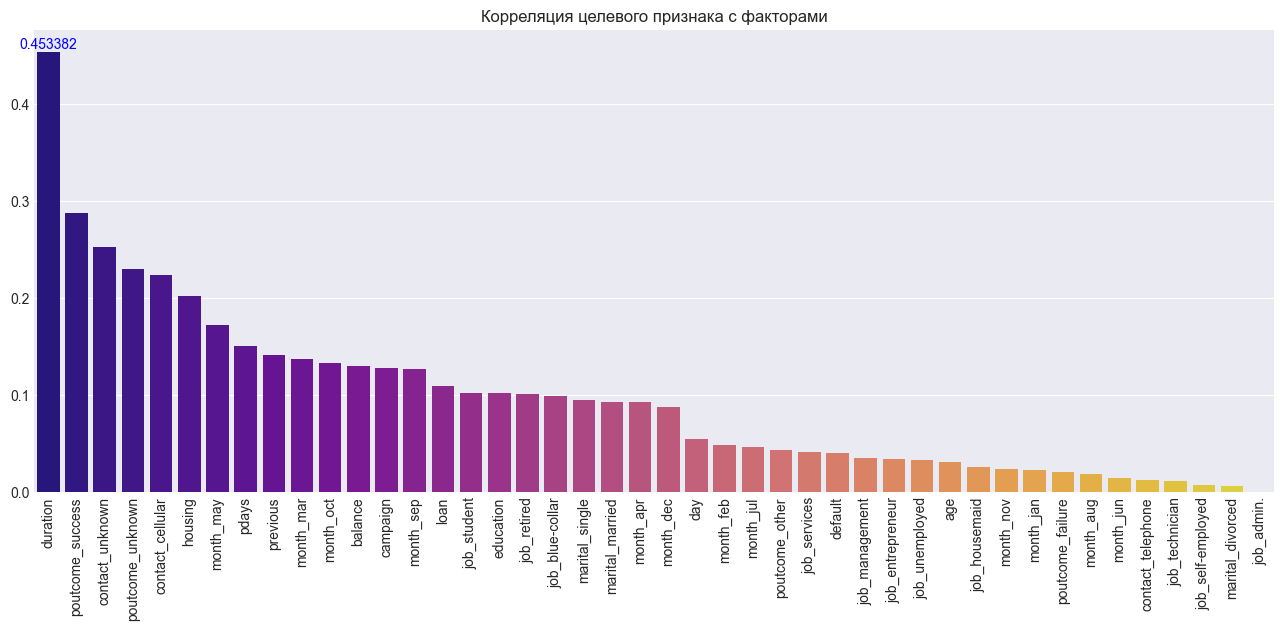

In [211]:
# корреляция целевого признака с факторами
fig = plt.figure(figsize=(16,6))

bp = sns.barplot(df.corr()['deposit'].abs().drop(columns='deposit').sort_values(ascending=False).drop('deposit', axis=0),
                 palette='plasma')
plt.ylabel('')
plt.grid(True, axis='y')
plt.xticks(rotation=90, fontsize=10)
bp.set_title('Корреляция целевого признака с факторами', fontsize=12)
bp.bar_label(bp.containers[0], color='b')
plt.show();


> * Сильной корреляции с целевым признаком нет ни у одного фактора.
> * Наибольшую корреляцию имеет фактор 'duration' (приблизительно 0.46).

**Корреляция признаков между собой**

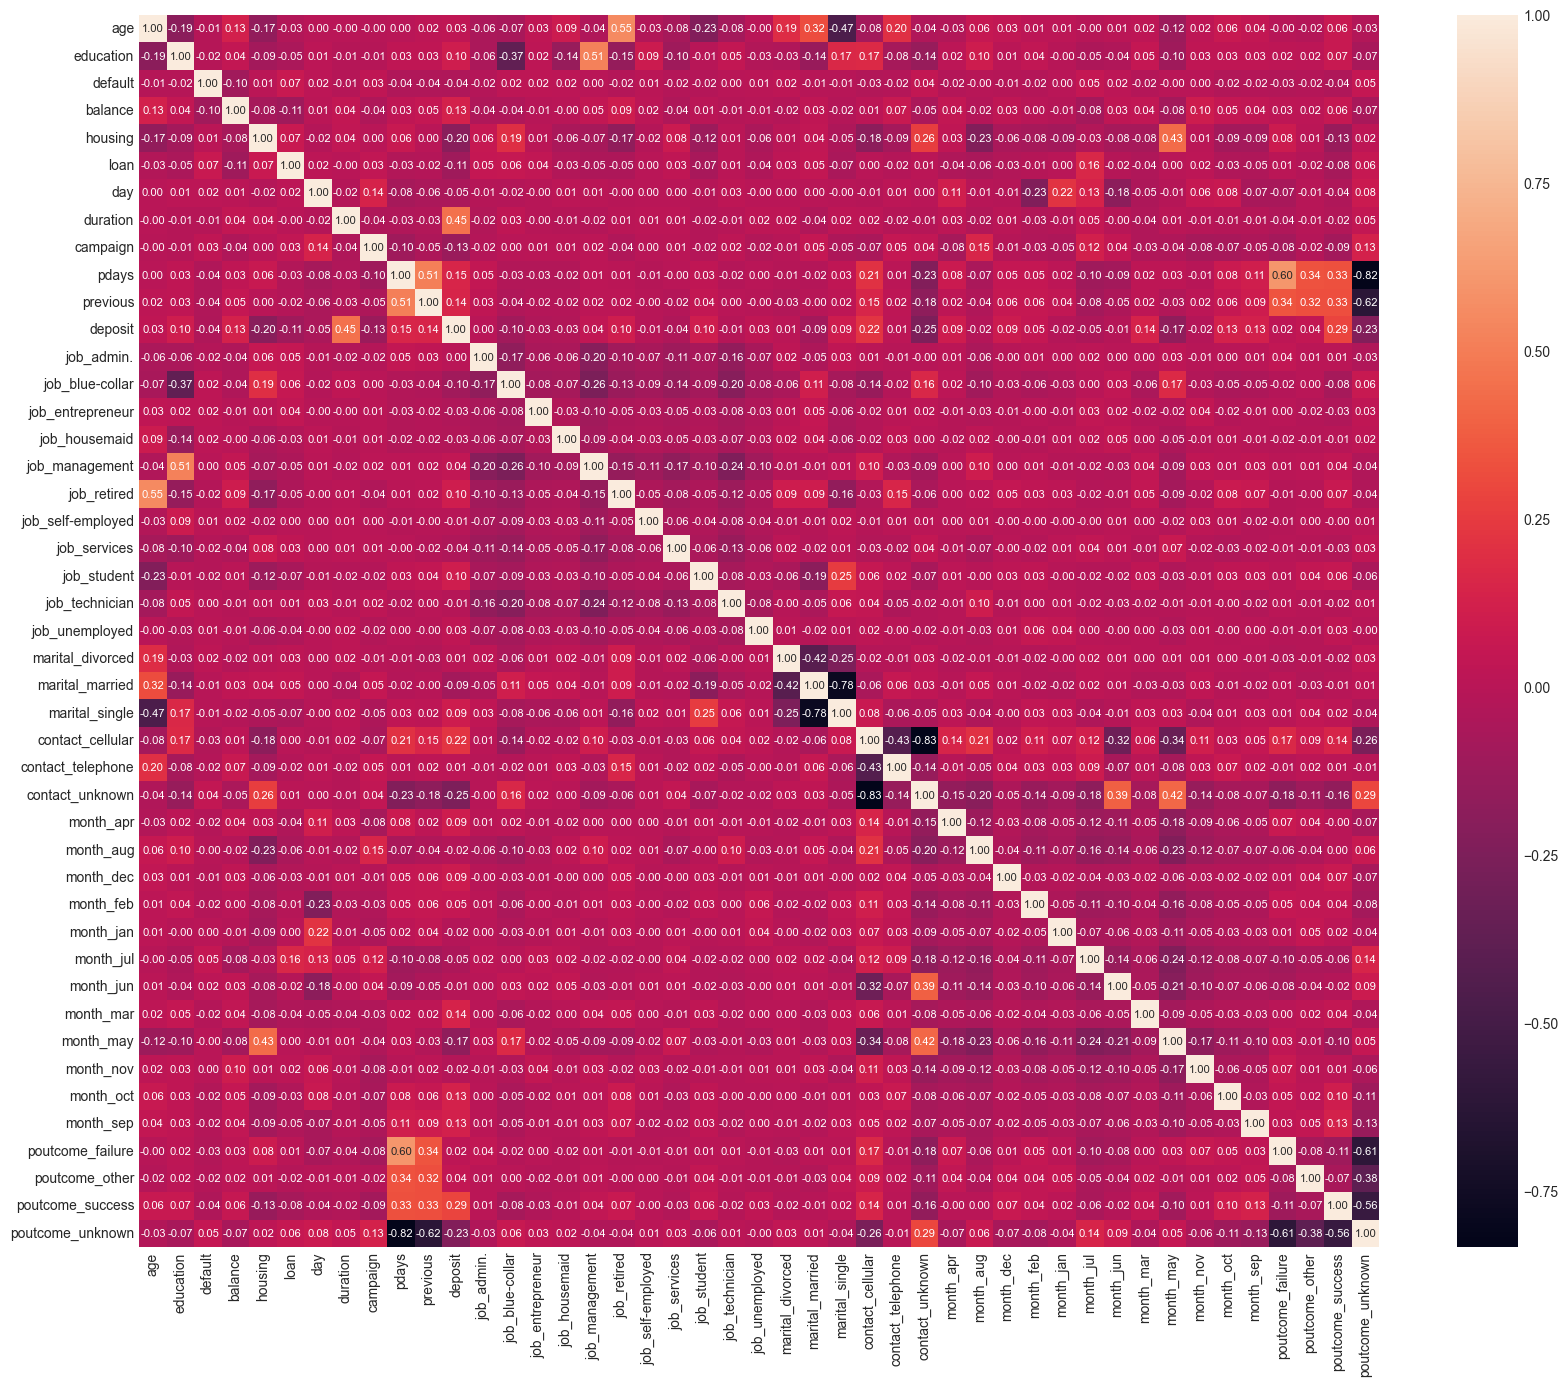

In [212]:
fig = plt.figure(figsize=(20,16))
sns.heatmap(df.corr(), annot=True, annot_kws={'size':8}, fmt='.2f');

> * Сильная обратная корреляция признаков pdays и poutcome_unknown (-0.82)
> * Сильная обратная корреляция признаков contact_cellular и contact_unknown (-0.83)
> * Близкая к сильной корреляция призаков marital_maried и marital_single (-0.78)

In [213]:
# Удалим признаки с высокой корреляцией
df.drop(columns=['poutcome_unknown', 'contact_unknown'], inplace=True)

#### Подготовка выборок

In [214]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(f'X_train shape: {X_train.shape}          X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}             y_test shape: {y_test.shape}')

X_train shape: (7131, 42)          X_test shape: (3513, 42)
y_train shape: (7131,)             y_test shape: (3513,)


#### Отбор наиболее значимых признаков

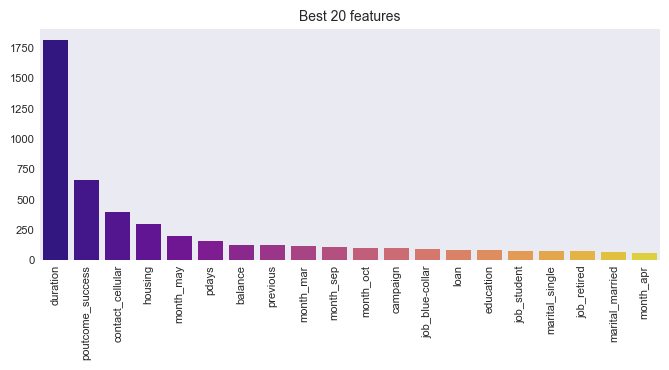

In [215]:
# с помощью SelectKBest отберем  20 наиболее подходящих признаков
SKB_model = SelectKBest(k=20)
SKB_model.fit(X_train, y_train)
best_features  = list(SKB_model.get_feature_names_out())
best_features.sort()
best_features_score = pd.Series(data=SKB_model.scores_, index=SKB_model.feature_names_in_).loc[best_features].sort_values(ascending=False)

# Best Features barplot
fig = plt.figure(figsize=(8,3))
bp = sns.barplot(x=best_features_score.index, y=best_features_score.values, palette='plasma')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('Best 20 features', fontsize=10)
plt.show;

#### Нормализация данных

In [216]:
# Процедура вывода распределения числовых признаков
def features_kdeplot(data, features, title):  
    fig = plt.figure(figsize=(12,3))
    fig.suptitle(title, fontsize=10)
    for i, feature in enumerate(features):
        ax = fig.add_subplot(2,6,i+1)
        sns.kdeplot(data, x=feature, ax=ax)
        ax.set_title(feature, fontdict={'size': 8})
        ax.set_xlabel('')
        ax.axes.tick_params(labelsize=8)
        ax.set_ylabel('')
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show();

Исследуем распределение числовых признаков

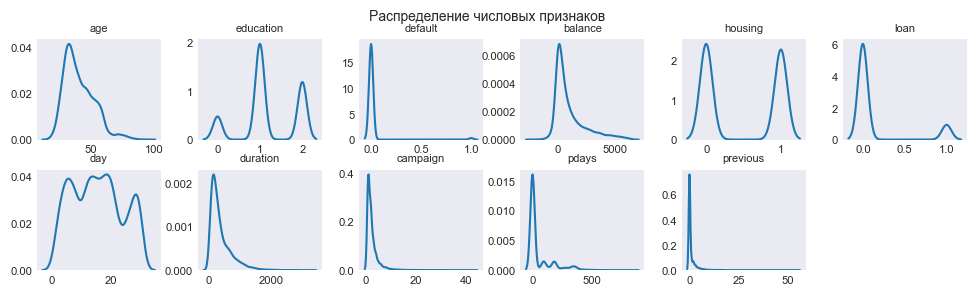

In [217]:
# Создадим список числовых признаков
features = list(X.select_dtypes(['int', 'float']).columns) # Список признаков

# Выведем распределение признаков
features_kdeplot(X_train, features, 'Рaспределение числовых признаков')

> Распределения признаков не являются нормальными.

In [218]:
# Нормализуем данные данные с помощью MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_20 = preprocessing.MinMaxScaler()
X_train_scaled_20 = scaler_20.fit_transform(X_train[best_features])
X_test_scaled_20 = scaler_20.transform(X_test[best_features])

Построим график распределений после стандартизации

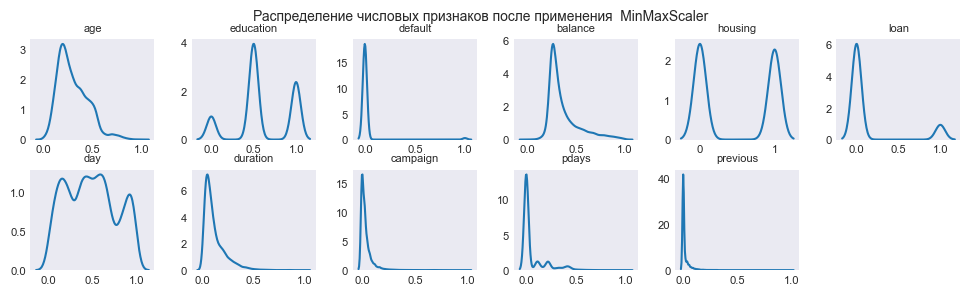

In [219]:
features_kdeplot(pd.DataFrame(X_train_scaled, columns=scaler.feature_names_in_), features,
                 'Распределение числовых признаков после применения  MinMaxScaler')

> Датасет подготовлен, переходим к решению задачи классификации

### Решение задачи классификации

In [220]:
# Процедура обучения модели  и вывода метрик
def model_learning_metrics(model, X_train, y_train, X_test, y_test, 
                           model_metrics, scaler='MinMaxScaler'):
    
    model_params=''
    model.fit(X_train, y_train) # обучение модели

    y_train_pred = model.predict(X_train) # предсказание на обучающей выборке
    y_test_pred = model.predict(X_test) # предсказание на тестовой выборке

    print('Метрики обучающей выборки\n',metrics.classification_report(y_train, y_train_pred))
    print('Метрики тестовой выборки\n',metrics.classification_report(y_test, y_test_pred))
        
    if type(model) == tree.DecisionTreeClassifier:
        model_params = ' ' + ' '.join([str(model.get_depth()),
                                       str(model.get_params()['min_samples_leaf']),
                                       str(model.get_params()['min_samples_split'])])
        print('-'*40, '\nГлубина дерева:', model.get_depth())
        print('Минимальное число объектов листа:', model.get_params()['min_samples_leaf'])
        print('Минимальное число объектов для деления листа:', model.get_params()['min_samples_split'])
        print('-'*40)
    
    if type(model) == ensemble.RandomForestClassifier:
        model_params = ' ' + ' '.join([str(model.get_params()['n_estimators']),
                                        str(model.get_params()['max_depth']),
                                        str(model.get_params()['min_samples_leaf']),
                                        str(model.get_params()['min_samples_split'])])
        print('-'*40, '\nЧисло деревьев:', model.get_params()['n_estimators'])
        print('Глубина дерева:', model.get_params()['max_depth'])
        print('Минимальное число объектов листа:', model.get_params()['min_samples_leaf'])
        print('Минимальное число объектов для деления листа:', model.get_params()['min_samples_split'])
        print('-'*40)
    
    if type(model) == ensemble._gb.GradientBoostingClassifier:
        model_params = ' ' + ' '.join([str(model.get_params()['n_estimators']),
                                        str(model.get_params()['max_depth']),
                                        str(model.get_params()['min_samples_leaf']),
                                        str(model.get_params()['min_samples_split'])])
        print('-'*40, '\nЧисло деревьев:', model.get_params()['n_estimators'])
        print('Глубина дерева:', model.get_params()['max_depth'])
        print(f'Скорость обучения: {model.get_params()['learning_rate']:.3f}')
        print('Минимальное число объектов листа:', model.get_params()['min_samples_leaf'])
        print('Минимальное число объектов для деления листа:', model.get_params()['min_samples_split'])
        print('-'*40)
    
    #Вычисление и запись метрик
    model_type = str(type(model))[8:][:-2].split('.')[-1] + model_params
    model_metrics = pd.concat([model_metrics, pd.DataFrame({
            'model': [model_type],
            'scaler': [scaler],
            'n_features': [model.n_features_in_],
            'acc_train': [round(metrics.accuracy_score(y_train, y_train_pred),2)],
            'acc_test': [round(metrics.accuracy_score(y_test, y_test_pred),2)],
            'f1_train': [round(float(metrics.f1_score(y_train, y_train_pred)),2)],
            'f1_test': [round(float(metrics.f1_score(y_test, y_test_pred)),2)]
            })], axis=0)
    return model_metrics

# Процедура создания списка уровня значимости признаков
def get_feature_scores(model):
    feature_scores = pd.Series(data = model.feature_importances_, index = model.feature_names_in_).sort_values(ascending=False)
    best_fs = list(feature_scores.index)[:20]
    best_fs.sort()
    print('20 наиболее значимых признаков:\n', best_fs)
    return feature_scores

In [221]:
# Создаем таблицу метрик
model_metrics = pd.DataFrame(columns=['model', 'scaler', 'n_features', 
                                      'acc_train', 'acc_test', 'f1_train', 'f1_test'])

#### Метод логистической регрессии

##### Предсказание по всем признакам

In [222]:
%%time
model = linear_model.LogisticRegression(solver='sag',
                                           max_iter=1000,
                                           verbose=10,
                                           n_jobs=-1, 
                                           random_state=42)

model_metrics = model_learning_metrics(model, 
                                        X_train_scaled, y_train, 
                                        X_test_scaled, y_test, 
                                        model_metrics)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 26 epochs took 0 seconds
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      3785
           1       0.83      0.79      0.81      3346

    accuracy                           0.83      7131
   macro avg       0.83      0.82      0.82      7131
weighted avg       0.83      0.83      0.83      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      1864
           1       0.85      0.78      0.81      1649

    accuracy                           0.83      3513
   macro avg       0.83      0.83      0.83      3513
weighted avg       0.83      0.83      0.83      3513

CPU times: total: 266 ms
Wall time: 275 ms


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s


##### Предсказание по 20 наиболее значимым признакам

In [223]:
%%time
model = linear_model.LogisticRegression(solver='sag',
                                           max_iter=1000,
                                           verbose=10,
                                           n_jobs=-1, 
                                           random_state=42)

model_metrics = model_learning_metrics(model, 
                                          X_train_scaled_20, y_train, 
                                          X_test_scaled_20, y_test, 
                                          model_metrics)

convergence after 21 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s


Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      3785
           1       0.83      0.76      0.80      3346

    accuracy                           0.82      7131
   macro avg       0.82      0.81      0.81      7131
weighted avg       0.82      0.82      0.82      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      1864
           1       0.84      0.76      0.80      1649

    accuracy                           0.82      3513
   macro avg       0.82      0.82      0.82      3513
weighted avg       0.82      0.82      0.82      3513

CPU times: total: 188 ms
Wall time: 172 ms


**Вывод метрик по результатам классификации**

In [224]:
model_metrics

,model,scaler,n_features,acc_train,acc_test,f1_train,f1_test
0,LogisticRegression,MinMaxScaler,42,0.83,0.83,0.81,0.81
0,LogisticRegression,MinMaxScaler,20,0.82,0.82,0.80,0.80


> Предсказание имеет точность около 80%, переобученность моделей не наблюдается, разницы в метриках при обучении на полном наборе признаков или на наборе 20 наиболее значимых признаков также не наблюдается.

> Построим другие модели классификации для улучшения метрик.

#### Дерево решений

##### Предсказание на полном наборе данных

In [225]:
tree_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
%time model_metrics = model_learning_metrics(tree_model, X_train, y_train, X_test, y_test, model_metrics, 'not scaled')
tree_feature_score = get_feature_scores(tree_model) # сохраним уровни значимости признаков
print('20 наиболее значимых признаков:\n', best_features)

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3785
           1       1.00      1.00      1.00      3346

    accuracy                           1.00      7131
   macro avg       1.00      1.00      1.00      7131
weighted avg       1.00      1.00      1.00      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1864
           1       0.80      0.75      0.77      1649

    accuracy                           0.79      3513
   macro avg       0.79      0.79      0.79      3513
weighted avg       0.79      0.79      0.79      3513

---------------------------------------- 
Глубина дерева: 31
Минимальное число объектов листа: 1
Минимальное число объектов для деления листа: 2
----------------------------------------
CPU times: total: 188 ms
Wall time: 181 ms
20 наиболее значимых признаков:
 ['age', 'balance', 'campaign', 

> * Модель явно переобучена.
> * Списки наиболее значимых признаков, отобранных процедурой и признаков дерева решений не совпадают.

##### Предсказание на 20 наиболее значимых признаках

In [226]:
%%time
tree_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
model_metrics = model_learning_metrics(tree_model, X_train[best_features], y_train, X_test[best_features], y_test, model_metrics, 'not scaled')

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3785
           1       1.00      1.00      1.00      3346

    accuracy                           1.00      7131
   macro avg       1.00      1.00      1.00      7131
weighted avg       1.00      1.00      1.00      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.77      0.79      0.78      1864
           1       0.75      0.73      0.74      1649

    accuracy                           0.76      3513
   macro avg       0.76      0.76      0.76      3513
weighted avg       0.76      0.76      0.76      3513

---------------------------------------- 
Глубина дерева: 36
Минимальное число объектов листа: 1
Минимальное число объектов для деления листа: 2
----------------------------------------
CPU times: total: 156 ms
Wall time: 151 ms


> Наблюдается явная переобученность дерева решений, построенного на 20 отобранных признаках.

> Выполним оптимизацию гиперпараметров методом GridSearch.

#### Подбор гиперпараметров для дерева решений (метод GridSearch)

In [227]:
# Процедура подбора гиперпараметров и построения кривых Accuracy
def DT_hyperparameters(X_train, y_train, X_test, y_test, param_space, model_metrics, scaler='not scaled'):

        # Запуск процедуры подбора параметров
        grid_search = GridSearchCV(estimator = tree.DecisionTreeClassifier(),
                                param_grid=param_space,
                                return_train_score = True,
                                scoring = 'accuracy',
                                cv=5,
                                verbose=10,
                                n_jobs=-1)
        grid_search.fit(X_train, y_train)

          
        model_metrics = model_learning_metrics(grid_search.best_estimator_, 
                                                X_train, y_train, X_test, y_test, 
                                                model_metrics, scaler=scaler)
                
        # Построение кривых Accuracy в зависимости от глубины дерева
        fig = plt.figure(figsize=(10,3))
        fig.suptitle('Кривые зависимости метрики Accuracy от глубины дерева')
        line1 = sns.lineplot(x=grid_search.cv_results_['param_max_depth'], 
                y=grid_search.cv_results_['mean_train_score'], label='train score')
        line2 = sns.lineplot(x=grid_search.cv_results_['param_max_depth'], 
                y=grid_search.cv_results_['mean_test_score'], color='maroon', label='test score')
        plt.scatter(x=[grid_search.best_params_['max_depth']],
                y=[grid_search.best_score_], color='green')
        plt.xticks(grid_search.cv_results_['param_max_depth'])
        plt.yticks(np.linspace(0.75,1,10).round(2).tolist())
        plt.grid()
        plt.legend(loc='upper left');
        
        return grid_search, model_metrics


##### Построение модели на всех признаках

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3785
           1       0.85      0.89      0.87      3346

    accuracy                           0.88      7131
   macro avg       0.88      0.88      0.88      7131
weighted avg       0.88      0.88      0.88      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.82      0.81      0.82      1864
           1       0.79      0.80      0.80      1649

    accuracy                           0.81      3513
   macro avg       0.81      0.81      0.81      3513
weighted avg       0.81      0.81      0.81      3513

---------------------------------------- 
Глубина дерева: 11
Минимальное число объектов листа: 5
Минимальное число объектов для деления листа: 9
----------------------------------------
CPU times: total: 14.4 s
Wall time: 1min 27

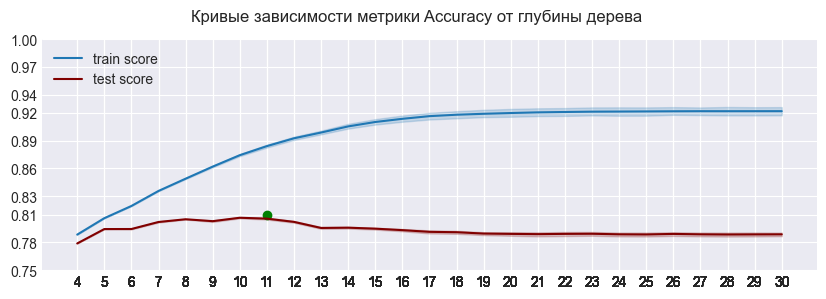

In [228]:
# Задаем пространство гиперпараметров
param_space = {'max_depth': np.linspace(4,30,27).astype('int').tolist(),
               'min_samples_leaf': np.linspace(2, 5, 4).astype('int').tolist(),
               'min_samples_split': [7, 8, 9, 10, 11]}
 
# Запускаем процедуру подбора параметров
%time grid_search, model_metrics = DT_hyperparameters(X_train, y_train, X_test, y_test, param_space, model_metrics)

tree_best_feature_score = get_feature_scores(grid_search.best_estimator_) # сохраним уровни значимости признаков
print('20 наиболее значимых признаков:\n', best_features)

##### Построение модели на 20 отобранных признаках

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.88      0.83      0.85      3785
           1       0.82      0.88      0.85      3346

    accuracy                           0.85      7131
   macro avg       0.85      0.85      0.85      7131
weighted avg       0.85      0.85      0.85      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      1864
           1       0.78      0.82      0.80      1649

    accuracy                           0.80      3513
   macro avg       0.80      0.81      0.80      3513
weighted avg       0.81      0.80      0.80      3513

---------------------------------------- 
Глубина дерева: 9
Минимальное число объектов листа: 5
Минимальное число объектов для деления листа: 9
----------------------------------------
CPU times: total: 11.8 s
Wall time: 1min 5s


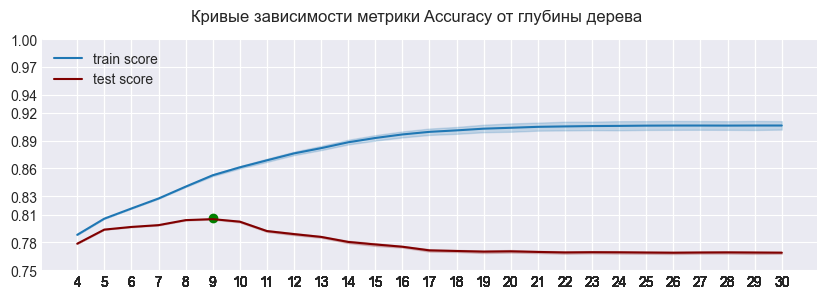

In [229]:
# Запускаем процедуру подбора параметров
%time grid_search, model_metrics = DT_hyperparameters(X_train[best_features], y_train, X_test[best_features], y_test, param_space, model_metrics)

> * Дерево решений с подобранным набором параметров все равно дает переобученность модели (F1-score для класса 1 равно 0.85, 0.87 на обучающей и 0.8 на тестовой выборках).
> * При построении модели на полном наборе признаков список наиболее значимых признаков не совпадает с отобранными ранее признаками

In [230]:
model_metrics

,model,scaler,n_features,acc_train,acc_test,f1_train,f1_test
0,LogisticRegression,MinMaxScaler,42,0.83,0.83,0.81,0.81
0,LogisticRegression,MinMaxScaler,20,0.82,0.82,0.80,0.80
0,DecisionTreeClassifier 31 1 2,not scaled,42,1.00,0.79,1.00,0.77
0,DecisionTreeClassifier 36 1 2,not scaled,20,1.00,0.76,1.00,0.74
0,DecisionTreeClassifier 11 5 9,not scaled,42,0.88,0.81,0.87,0.80
0,DecisionTreeClassifier 9 5 9,not scaled,20,0.85,0.80,0.85,0.80


### Ансамбли моделей и построение прогноза

#### Случайный лес
**Построение модели на всех признаках**

In [231]:
# Обучение модели случайного леса
forest_model = ensemble.RandomForestClassifier(n_estimators = 100,
                                               criterion = 'gini',
                                               min_samples_leaf = 5,
                                               max_depth = 10,
                                               random_state = 42)

model_metrics = model_learning_metrics(forest_model, X_train, y_train, X_test, y_test, model_metrics, 'not scaled')
forest_feature_score = get_feature_scores(forest_model)
print('20 наиболее значимых признаков:\n', best_features)

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      3785
           1       0.84      0.88      0.86      3346

    accuracy                           0.87      7131
   macro avg       0.87      0.87      0.87      7131
weighted avg       0.87      0.87      0.87      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      1864
           1       0.82      0.86      0.84      1649

    accuracy                           0.85      3513
   macro avg       0.85      0.85      0.85      3513
weighted avg       0.85      0.85      0.85      3513

---------------------------------------- 
Число деревьев: 100
Глубина дерева: 10
Минимальное число объектов листа: 5
Минимальное число объектов для деления листа: 2
----------------------------------------
20 наиболее значимых признаков:
 ['age', 'balance', 'campaign', 'contact_cellular', 'da

**Построение модели на 20 отобранных признаках**

In [232]:
# Обучение модели случайного леса
forest_model = ensemble.RandomForestClassifier(n_estimators = 100,
                                               criterion = 'gini',
                                               min_samples_leaf = 5,
                                               max_depth = 10,
                                               random_state = 42)

model_metrics = model_learning_metrics(forest_model, 
                                       X_train[best_features], y_train, 
                                       X_test[best_features], y_test, 
                                       model_metrics, 'not scaled')

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      3785
           1       0.83      0.87      0.85      3346

    accuracy                           0.86      7131
   macro avg       0.86      0.86      0.86      7131
weighted avg       0.86      0.86      0.86      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1864
           1       0.82      0.84      0.83      1649

    accuracy                           0.84      3513
   macro avg       0.84      0.84      0.84      3513
weighted avg       0.84      0.84      0.84      3513

---------------------------------------- 
Число деревьев: 100
Глубина дерева: 10
Минимальное число объектов листа: 5
Минимальное число объектов для деления листа: 2
----------------------------------------


##### Подбор гиперпараметров случайного леса методом Optuna

**Построение модели на всех признаках**

In [233]:
# Процедура вычисления случайного леса на пространстве гиперпараметров
def optuna_rf(trial):
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 140, 1)
    max_depth = trial.suggest_int('max_depth', 5, 10, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 3, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 6, 1)
    
    # Создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          criterion='gini',
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          min_samples_split=min_samples_split,
                                          verbose=1,
                                          random_state=42)
    # Обучаем модель
    model.fit(X_train, y_train)
    # Вычисляем метрику
    r1 = metrics.f1_score(y_train, model.predict(X_train))
    return r1

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
%time study.optimize(optuna_rf, n_trials=20)

[I 2025-05-17 14:04:20,195] A new study created in memory with name: RandomForestClassifier
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:    0.0s finished
[I 2025-05-17 14:04:21,388] Trial 0 finished with value: 0.8547108893454652 and parameters: {'n_estimators': 109, 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 6}. Best is trial 0 with value: 0.8547108893454652.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:    0.0s finished
[I 2025-05-17 14:04:22,387] Trial 1 finished with value: 0.8683097564532595 and parameters: {'n_estimators': 103, 'max_depth': 10, 'min_samples_leaf': 3, 'min

CPU times: total: 20.8 s
Wall time: 21.1 s


In [234]:
print('Лучшие параметры случайного леса:')
print(study.best_params)

# Создаем модель на лучших параметрах
forest_model = ensemble.RandomForestClassifier(**study.best_params, 
                                               verbose=0,
                                               random_state=42)

%time model_metrics = model_learning_metrics(forest_model, X_train, y_train, X_test, y_test, model_metrics, 'not scaled')
forest_best_feature_sc = get_feature_scores(forest_model)
print('20 наиболее значимых признаков:\n', best_features)

Лучшие параметры случайного леса:
{'n_estimators': 115, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4}
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3785
           1       0.85      0.89      0.87      3346

    accuracy                           0.88      7131
   macro avg       0.88      0.88      0.88      7131
weighted avg       0.88      0.88      0.88      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1864
           1       0.82      0.86      0.84      1649

    accuracy                           0.85      3513
   macro avg       0.85      0.85      0.85      3513
weighted avg       0.85      0.85      0.85      3513

---------------------------------------- 
Число деревьев: 115
Глубина дерева: 10
Минимальное число объектов листа: 2
Минимальное число объектов для деления листа: 4
--------

**Построение модели на 20 отобранных признаках**

In [235]:
# Процедура вычисления случайного леса на пространстве гиперпараметров
def optuna_rf(trial):
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 140, 1)
    max_depth = trial.suggest_int('max_depth', 5, 10, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 3, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 6, 1)
    
    # Создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          criterion='gini',
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          min_samples_split=min_samples_split,
                                          verbose=1,
                                          random_state=42)
    # Обучаем модель
    model.fit(X_train[best_features], y_train)
    # Вычисляем метрику
    r1 = metrics.f1_score(y_train, model.predict(X_train[best_features]))
    return r1

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
%time study.optimize(optuna_rf, n_trials=20)

[I 2025-05-17 14:04:43,002] A new study created in memory with name: RandomForestClassifier
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    0.0s finished
[I 2025-05-17 14:04:44,039] Trial 0 finished with value: 0.8365086397873283 and parameters: {'n_estimators': 134, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.8365086397873283.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:    0.0s finished
[I 2025-05-17 14:04:44,781] Trial 1 finished with value: 0.8234768359898704 and parameters: {'n_estimators': 109, 'max_depth': 6, 'min_samples_leaf': 3, 'min_

CPU times: total: 18.2 s
Wall time: 18.3 s


In [236]:
print('Лучшие параметры случайного леса:')
print(study.best_params)

# Создаем модель на лучших параметрах
forest_model = ensemble.RandomForestClassifier(**study.best_params, 
                                               verbose=0,
                                               random_state=42)

%time model_metrics = model_learning_metrics(forest_model, X_train[best_features], y_train, X_test[best_features], y_test, model_metrics, 'not scaled')


Лучшие параметры случайного леса:
{'n_estimators': 102, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 4}
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      3785
           1       0.84      0.88      0.86      3346

    accuracy                           0.86      7131
   macro avg       0.86      0.86      0.86      7131
weighted avg       0.86      0.86      0.86      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1864
           1       0.81      0.85      0.83      1649

    accuracy                           0.84      3513
   macro avg       0.84      0.84      0.84      3513
weighted avg       0.84      0.84      0.84      3513

---------------------------------------- 
Число деревьев: 102
Глубина дерева: 10
Минимальное число объектов листа: 3
Минимальное число объектов для деления листа: 4
--------

> Для случайного леса даже с лучшими параметрами наблюдается переобученность модели

In [237]:
model_metrics

,model,scaler,n_features,acc_train,acc_test,f1_train,f1_test
0,LogisticRegression,MinMaxScaler,42,0.83,0.83,0.81,0.81
0,LogisticRegression,MinMaxScaler,20,0.82,0.82,0.80,0.80
0,DecisionTreeClassifier 31 1 2,not scaled,42,1.00,0.79,1.00,0.77
0,DecisionTreeClassifier 36 1 2,not scaled,20,1.00,0.76,1.00,0.74
0,DecisionTreeClassifier 11 5 9,not scaled,42,0.88,0.81,0.87,0.80
0,DecisionTreeClassifier 9 5 9,not scaled,20,0.85,0.80,0.85,0.80
0,RandomForestClassifier 100 10 5 2,not scaled,42,0.87,0.85,0.86,0.84
0,RandomForestClassifier 100 10 5 2,not scaled,20,0.86,0.84,0.85,0.83
0,RandomForestClassifier 115 10 2 4,not scaled,42,0.88,0.85,0.87,0.84
0,RandomForestClassifier 102 10 3 4,not scaled,20,0.86,0.84,0.86,0.83


#### Градиентный бустинг

**Построение модели на полном наборе признаков**

In [238]:
boosting_model = GradientBoostingClassifier(learning_rate = 0.05,
                                            n_estimators = 300,
                                            min_samples_leaf = 5,
                                            min_samples_split = 9,
                                            max_depth = 10,
                                            random_state = 42)

%time model_metrics = model_learning_metrics(boosting_model, X_train, y_train, X_test, y_test, model_metrics, 'not scaled')


Метрики обучающей выборки
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3785
           1       1.00      1.00      1.00      3346

    accuracy                           1.00      7131
   macro avg       1.00      1.00      1.00      7131
weighted avg       1.00      1.00      1.00      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      1864
           1       0.84      0.87      0.86      1649

    accuracy                           0.86      3513
   macro avg       0.86      0.86      0.86      3513
weighted avg       0.86      0.86      0.86      3513

---------------------------------------- 
Число деревьев: 300
Глубина дерева: 10
Скорость обучения: 0.050
Минимальное число объектов листа: 5
Минимальное число объектов для деления листа: 9
----------------------------------------
CPU times: total: 21.5 s
Wall time: 21.9 s


**Построение модели на на 20 отобранных признаках**

In [239]:
boosting_model = GradientBoostingClassifier(learning_rate = 0.05,
                                                     n_estimators = 300,
                                                     min_samples_leaf = 5,
                                                     min_samples_split = 9,
                                                     max_depth = 10,
                                                     random_state = 42)

%time model_metrics = model_learning_metrics(boosting_model, X_train[best_features], y_train, X_test[best_features], y_test, model_metrics, 'not scaled')

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3785
           1       1.00      0.99      0.99      3346

    accuracy                           0.99      7131
   macro avg       0.99      0.99      0.99      7131
weighted avg       0.99      0.99      0.99      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1864
           1       0.81      0.82      0.81      1649

    accuracy                           0.82      3513
   macro avg       0.82      0.82      0.82      3513
weighted avg       0.82      0.82      0.82      3513

---------------------------------------- 
Число деревьев: 300
Глубина дерева: 10
Скорость обучения: 0.050
Минимальное число объектов листа: 5
Минимальное число объектов для деления листа: 9
----------------------------------------
CPU times: total: 15.4 s
Wall time: 15.7 s


> Модель со взятыми параметрами переобучена

##### Подбор параметров модели методом Optuna

**Построение модели на полном наборе признаков**

In [240]:
# Процедура вычисления градиентного бустинга на пространстве гиперпараметров
def optuna_rf(trial):
    # Задаем пространство поиска гиперпараметров
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.04)
    n_estimators = trial.suggest_int('n_estimators', 200, 250, 1)
    max_depth = trial.suggest_int('max_depth', 5, 7, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 10, 1)
        
    # Создаем модель
    model = GradientBoostingClassifier(learning_rate = learning_rate,
                                        n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        min_samples_split=min_samples_split,
                                        random_state=42)
    # Обучаем модель
    model.fit(X_train, y_train)
    # Вычисляем метрику
    r1 = metrics.f1_score(y_train, model.predict(X_train))
    return r1

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
%time study.optimize(optuna_rf, n_trials=30)

[I 2025-05-17 14:05:40,283] A new study created in memory with name: RandomForestClassifier
[I 2025-05-17 14:05:48,347] Trial 0 finished with value: 0.891766075065464 and parameters: {'learning_rate': 0.02416387635350296, 'n_estimators': 217, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 4}. Best is trial 0 with value: 0.891766075065464.
[I 2025-05-17 14:05:57,164] Trial 1 finished with value: 0.8863372093023256 and parameters: {'learning_rate': 0.019530432285844924, 'n_estimators': 240, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 4}. Best is trial 0 with value: 0.891766075065464.
[I 2025-05-17 14:06:03,950] Trial 2 finished with value: 0.8913551401869159 and parameters: {'learning_rate': 0.03878126130688122, 'n_estimators': 237, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 7}. Best is trial 0 with value: 0.891766075065464.
[I 2025-05-17 14:06:12,158] Trial 3 finished with value: 0.8802909090909091 and parameters: {'learning_rate': 0.0187034

CPU times: total: 4min 41s
Wall time: 4min 46s


In [241]:
# Создаем модель на лучших параметрах
boosting_model = GradientBoostingClassifier(**study.best_params, 
                                               verbose=0,
                                               random_state=42)

%time model_metrics = model_learning_metrics(boosting_model, X_train, y_train, X_test, y_test, model_metrics, 'not scaled')
boosting_best_feature_sc = get_feature_scores(boosting_model)
print('20 наиболее значимых признаков:\n', best_features)

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      3785
           1       0.94      0.96      0.95      3346

    accuracy                           0.96      7131
   macro avg       0.95      0.96      0.96      7131
weighted avg       0.96      0.96      0.96      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      1864
           1       0.84      0.87      0.86      1649

    accuracy                           0.86      3513
   macro avg       0.86      0.86      0.86      3513
weighted avg       0.86      0.86      0.86      3513

---------------------------------------- 
Число деревьев: 250
Глубина дерева: 7
Скорость обучения: 0.040
Минимальное число объектов листа: 2
Минимальное число объектов для деления листа: 6
----------------------------------------
CPU times: total: 11 s
Wall time: 11.2 s
20 наиболее значимых п

**Построение модели на 20 наиболее значимых признаках**

In [242]:
# Процедура вычисления градиентного бустинга на пространстве гиперпараметров
def optuna_rf(trial):
    # Задаем пространство поиска гиперпараметров
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.04)
    n_estimators = trial.suggest_int('n_estimators', 200, 250, 1)
    max_depth = trial.suggest_int('max_depth', 5, 7, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 10, 1)
        
    # Создаем модель
    model = GradientBoostingClassifier(learning_rate = learning_rate,
                                        n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        random_state=42)
    # Обучаем модель
    model.fit(X_train[best_features], y_train)
    # Вычисляем метрику
    r1 = metrics.f1_score(y_train, model.predict(X_train[best_features]))
    return r1

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
%time study.optimize(optuna_rf, n_trials=30)

[I 2025-05-17 14:10:37,963] A new study created in memory with name: RandomForestClassifier
[I 2025-05-17 14:10:45,232] Trial 0 finished with value: 0.8892484188851302 and parameters: {'learning_rate': 0.02716520369765607, 'n_estimators': 201, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 6}. Best is trial 0 with value: 0.8892484188851302.
[I 2025-05-17 14:10:52,105] Trial 1 finished with value: 0.8582677165354331 and parameters: {'learning_rate': 0.013459852311662236, 'n_estimators': 243, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4}. Best is trial 0 with value: 0.8892484188851302.
[I 2025-05-17 14:10:59,716] Trial 2 finished with value: 0.8946362968405585 and parameters: {'learning_rate': 0.0300028204346982, 'n_estimators': 235, 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 9}. Best is trial 2 with value: 0.8946362968405585.
[I 2025-05-17 14:11:04,196] Trial 3 finished with value: 0.8373924456759516 and parameters: {'learning_rate': 0.0115

CPU times: total: 3min 21s
Wall time: 3min 26s


In [243]:
# Создаем модель на лучших параметрах
boosting_model = GradientBoostingClassifier(**study.best_params, 
                                               verbose=0,
                                               random_state=42)

%time model_metrics = model_learning_metrics(boosting_model, X_train[best_features], y_train, X_test[best_features], y_test, model_metrics, 'not scaled')


Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      3785
           1       0.90      0.92      0.91      3346

    accuracy                           0.91      7131
   macro avg       0.91      0.91      0.91      7131
weighted avg       0.91      0.91      0.91      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1864
           1       0.81      0.83      0.82      1649

    accuracy                           0.83      3513
   macro avg       0.83      0.83      0.83      3513
weighted avg       0.83      0.83      0.83      3513

---------------------------------------- 
Число деревьев: 249
Глубина дерева: 7
Скорость обучения: 0.037
Минимальное число объектов листа: 3
Минимальное число объектов для деления листа: 7
----------------------------------------
CPU times: total: 8.2 s
Wall time: 8.47 s


> Гиперпараметры, подобранные методом Optuna, приводят к переобученности модели.

#### Стекинг
Объединим четыре модели: LogisticRegression, DesicionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier

In [244]:
# Список моделей стекинга
estimators = [
    ('lr', linear_model.LogisticRegression(solver='sag',
                                          max_iter=1000,
                                          random_state=42)),
    ('dt', tree.DecisionTreeClassifier(criterion='entropy',
                                          max_depth=10,
                                          min_samples_leaf=3,
                                          min_samples_split=6,
                                          random_state=42)),
    ('rf', ensemble.RandomForestClassifier(n_estimators = 101,
                                          criterion = 'gini',
                                          min_samples_leaf = 2,
                                          min_samples_split = 4,
                                          max_depth = 10,
                                          random_state = 42)),
    ('gb', ensemble.GradientBoostingClassifier(learning_rate = 0.038,
                                              n_estimators = 200,
                                              min_samples_leaf = 4,
                                              max_depth = 7,
                                              random_state = 42))
]

##### Построение модели на всех признаках

In [245]:
meta_model = ensemble.StackingClassifier(
    estimators = estimators,
    final_estimator=linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42),
    verbose=1,
    n_jobs=-1
)

meta_model.fit(X_train_scaled, y_train)
%time model_metrics = model_learning_metrics(meta_model, X_train_scaled, y_train, X_test_scaled, y_test, model_metrics)

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      3785
           1       0.90      0.93      0.91      3346

    accuracy                           0.92      7131
   macro avg       0.92      0.92      0.92      7131
weighted avg       0.92      0.92      0.92      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      1864
           1       0.84      0.87      0.85      1649

    accuracy                           0.86      3513
   macro avg       0.86      0.86      0.86      3513
weighted avg       0.86      0.86      0.86      3513

CPU times: total: 375 ms
Wall time: 39.9 s


##### Построение модели на 20 отобранных признаках

In [246]:
meta_model = ensemble.StackingClassifier(
    estimators = estimators,
    final_estimator=linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42),
    verbose=1,
    n_jobs=-1
)

meta_model.fit(X_train_scaled, y_train)
%time model_metrics = model_learning_metrics(meta_model, X_train_scaled_20, y_train, X_test_scaled_20, y_test, model_metrics)

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3785
           1       0.86      0.88      0.87      3346

    accuracy                           0.88      7131
   macro avg       0.87      0.88      0.87      7131
weighted avg       0.88      0.88      0.88      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      1864
           1       0.82      0.83      0.83      1649

    accuracy                           0.84      3513
   macro avg       0.84      0.84      0.84      3513
weighted avg       0.84      0.84      0.84      3513

CPU times: total: 453 ms
Wall time: 30.6 s


#### Итоги

In [247]:
# Выводим метрики построенных моделей
model_metrics

,model,scaler,n_features,acc_train,acc_test,f1_train,f1_test
0,LogisticRegression,MinMaxScaler,42,0.83,0.83,0.81,0.81
0,LogisticRegression,MinMaxScaler,20,0.82,0.82,0.80,0.80
0,DecisionTreeClassifier 31 1 2,not scaled,42,1.00,0.79,1.00,0.77
0,DecisionTreeClassifier 36 1 2,not scaled,20,1.00,0.76,1.00,0.74
0,DecisionTreeClassifier 11 5 9,not scaled,42,0.88,0.81,0.87,0.80
0,DecisionTreeClassifier 9 5 9,not scaled,20,0.85,0.80,0.85,0.80
0,RandomForestClassifier 100 10 5 2,not scaled,42,0.87,0.85,0.86,0.84
0,RandomForestClassifier 100 10 5 2,not scaled,20,0.86,0.84,0.85,0.83
0,RandomForestClassifier 115 10 2 4,not scaled,42,0.88,0.85,0.87,0.84
0,RandomForestClassifier 102 10 3 4,not scaled,20,0.86,0.84,0.86,0.83


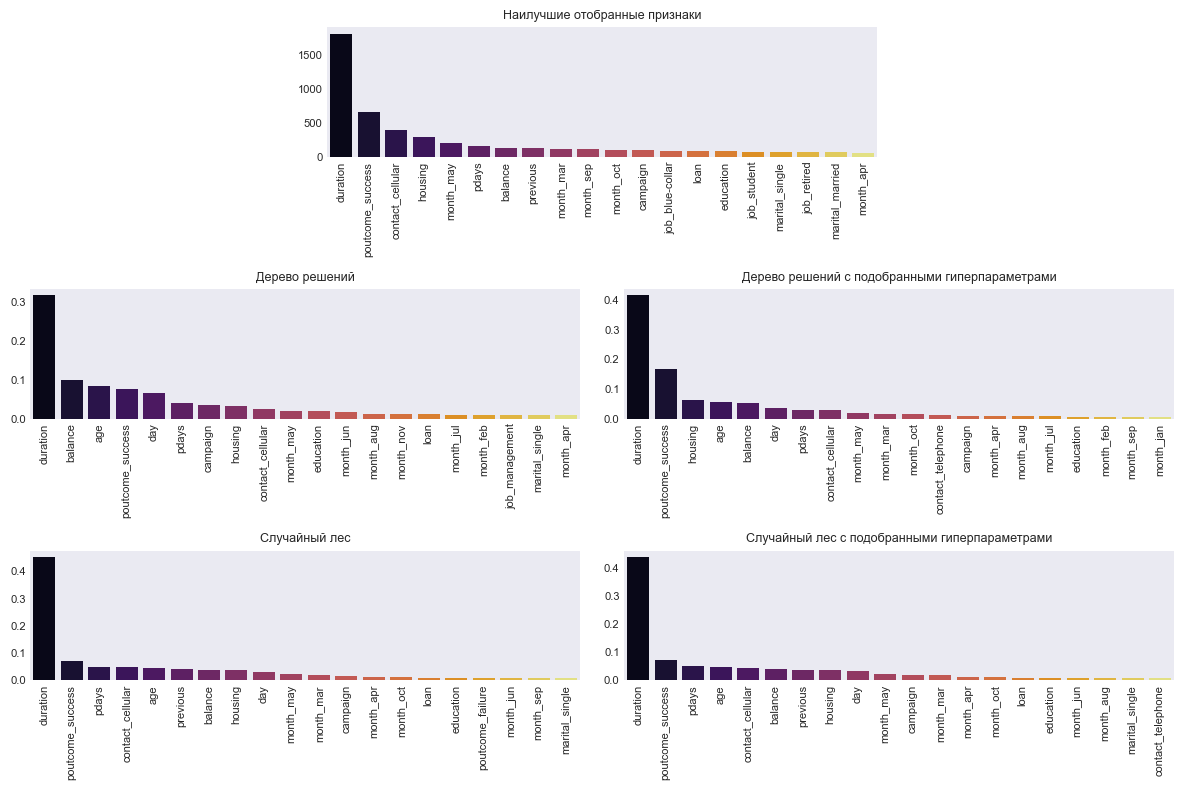

In [248]:
# Barplot procedure
def features_barplot(x, y, ax, title):
    sns.barplot(x=x, y=y, palette='inferno', ax=ax)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel('')
    ax.set_title(title, fontsize=9)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(3,4,(2,3))
features_barplot(best_features_score.index, best_features_score.values, 
                 ax, 'Наилучшие отобранные признаки')
ax = fig.add_subplot(3,4,(5,6))
features_barplot(list(tree_feature_score.index)[:20], list(tree_feature_score.values)[:20], 
                 ax, 'Дерево решений')
ax = fig.add_subplot(3,4,(7,8))
features_barplot(list(tree_best_feature_score.index)[:20], list(tree_best_feature_score.values)[:20], 
                 ax, 'Дерево решений c подобранными гиперпараметрами')
ax = fig.add_subplot(3,4,(9,10))
features_barplot(list(forest_feature_score.index)[:20], list(forest_feature_score.values)[:20], 
                      ax, 'Случайный лес')
ax = fig.add_subplot(3,4,(11,12))
features_barplot(list(forest_best_feature_sc.index)[:20], list(forest_best_feature_sc.values)[:20], 
                 ax, 'Случайный лес с подобранными гиперпараметрами')

fig.tight_layout()
plt.show();

> * Все построенные модели показывают метрики accuracy и f1-score, не превышающие 0.86 на тестовой выборке.
> * Наилучший результат показала модель случайного леса с параметрами: 100 деревьев глубины 10 с минимальным числом объектов листа равным 5:
>   * F1-score равен 0.86 и 0.84, Accuracy равно 0.87 и 0.85 на обучающей и тестовой выборках для модели, обученной на всех признаках
>   *  F1-score равен 0.85 и 0.83, Accuracy равно 0.86 и 0.84 на обучающей и тестовой выборках для модели, обученной на 20 отобранных признаках 
> * Модели, построенные на гиперпараметрах, подобранных методом GridSearch в случае дерева решений и методом Optuna в случае случайного леса, дают переобученность модели.
> * Наиболее значимым признаков во всех построенных моделях является признак 'duration' - длительность общения с клиентом по телефону во время рекламной кампании.
> * Кроме того, во всех моделях значимыми являются признаки:
>   * 'balance' - баланс клиентов,
>   * 'age' - возраст клиента
>   * 'contact_cellular' - бумажная рассылка в рекламную кампанию,
>   * 'day' - день последнего контакта
>   * 'pdays' - количество дней, прошедших с последнего контакта в предыдущую кампанию до контакта в текущей кампании
>   * 'poutcome_success' - успешный результат в предыдущую кампанию
>   * 'previous' - число контактов в предыдущую кампанию
>   * 'housing' - наличие кредита на жилье
>   * 'month_may' - месяц контакта
>   * 'month_mar' - месяц контакта
>   * 'month_apr'- месяц контакта
>   * 'month_oct'- месяц контакта